In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import rpy2.rinterface

%load_ext rpy2.ipython

plt.style.use("ggplot")

# Updating critical loads for water

## Part B: Statistical modelling

## 1. Read input data

In [2]:
# Period of interest
st_yr = 1990
end_yr = 2021

# CSV from Part A
csv_path = f"/home/jovyan/shared/critical_loads/spatial_interpolation/norway_annual_chem_toc_no3_{st_yr}-{end_yr}.csv"

In [3]:
# Read data
df = pd.read_csv(csv_path)
df.head()

,station_id,station_name,utm_north,utm_east,year,TOC_mgpl,NO3_NO2_ugpl,runoff_mmpyr,elevation_m
0,26070,Langtjern,6.634299e+06,323345.999797,1995,11.7,46.0,532,274
1,26070,Langtjern,6.634299e+06,323345.999797,1996,19.6,13.0,532,274
2,26070,Langtjern,6.634299e+06,323345.999797,1997,11.0,54.0,532,274
3,26070,Langtjern,6.634299e+06,323345.999797,1998,13.1,58.0,532,274
4,26070,Langtjern,6.634299e+06,323345.999797,1999,13.1,53.0,532,274


## 2. Generalised Additive Models (GAMs)

Using GAMs, we will model TOC and NO3 concentrations as the sum of (non-linear) functions of space and/or time. The most obvious approach is to use a 2D spline, `s(x, y)`, to model the spatial component, and 1D splines, `s(t)`, to model other variables, including variation over time. Note that when a 2D spline is defined in this way, it uses a single smoothing parameter in both the `x` and `y` directions. This is reasonable if `x` and `y` have the same scale - for example if they are in projected co-ordinates where `x` and `y` are both UTM Zone 33N metres. 

An alternative approach is to fit a tensor spline, either just for the spatial component,`te(x, y)`, or for the other variables too (e.g. the combined spatio-temporal variation, `te(x, y, t)`). Both these options will allow different smoothing factors in the `x`, `y` and `t` dimensions.

The first option, `Conc ~ s(x, y) + s(t)`, seems intuitively sensible and is probably simplest. However, the second option, `Conc ~ te(x, y, t)` has some additional flexibility and is also worth exploring.

### 2.1. Choosing `k`

Each spline takes a parameter `k`, which is the number of "knots". More "knots" means more flexibility, but it also increases the computational complexity of fitting and predicting. It is important that `k` is large enough to allow the model to fit patterns in the data. Making `k` too large does not necessarily cause overfitting, due to the way the splines are penalised; the main drawback is the increase in processing time. See the documentation [here](https://rdrr.io/cran/mgcv/man/choose.k.html) for details. In particular:

> [...] exact choice of k is not generally critical: it should be chosen to be large enough that you are reasonably sure of having enough degrees of freedom to represent the underlying "truth" reasonably well, but small enough to maintain reasonable computational efficiency. Clearly "large" and "small" are dependent on the particular problem being addressed.

`mgcv` includes a function called `gam.check` to help with selecting `k`. The output for a questionable model will look like this:

    Basis dimension (k) checking results. Low p-value (k-index<1) may
    indicate that k is too low, especially if edf is close to k'.

                             k'   edf k-index p-value    
    s(utm_east,utm_north) 29.00 28.15    0.37  <2e-16 ***
    s(year)                9.00  5.85    0.86  <2e-16 ***
    
In the output above note that, for both parameters, the value of `k` is close to the effective degrees of freedom (`edf`), the `k-index` is less than 1, and the `p-value` is small. This is **bad**. According to the documentation [here](https://www.rdocumentation.org/packages/mgcv/versions/1.8-41/topics/gam.check), a good strategy is to double the value of `k` and refit the model, and keep doing this until the `p-values` are **not** significant (which implies there is no significant structure in the residuals).

The `k` value for each variable must be smaller than the number of unique values in the data for that variable. For example, in the analysis here, there are only 25 years between 1995 and 2019, so the most flexible spline possible is `s(year, k=24)`. As noted above, for 2D splines, the same value of `k` applies in both directions and is set as `s(x, y, k=100)`. For tensor splines, it is possible to specify `k` for each dimension: for example, `te(x, y, t, k=c(10, 10, 2))` assigns the same flexibility in the `x` and `y` directions, and less in the `t` direction. The overall value of `k` for a tensor spline is the *product* of the `k` values for each dimension i.e. $10 \times 10 \times 2 = 200$ in the example here.

### 2.2. Choosing the `family` and `link` function

#### 2.2.1. `family`

GAMs can use `link` functions and distribution `families` in the same way as GLMs. All this gets complicated quickly; this section just summarises some practical tips.

The `family` specifies the expected **distribution of the residuals** i.e. the **conditional distribution** of `y` given `x`, which is the distribution of the noise around the fitted curve. The default is a Gaussian which, for a simple linear model, looks like this

$$ y = X \beta + \epsilon$$

where $X \beta$ is called the **linear predictor** and $\epsilon \sim \mathcal{N}(0, \sigma^2)$ is independent and identically distributed (i.i.d.) Gaussian noise. In more statistical language, this can be written as

$$Y|X \sim \mathcal{N}({X \beta}, \sigma^2)$$
$$\mathbb{E} = X \beta$$

In other words, the **conditional distribution** of `y` given `x` is Gaussian with an **expected value** of ${X \beta}$.

**Note:** This *does not* imply that the overall distribution of `y` (i.e. the *marginal* distribution) is Gaussian. The `family` assumption applies only to the *conditional* distribution, $Y|X$, which is the same as saying it applies to the residuals. `y` itself does not need to be Gaussian - see [here](https://stats.stackexchange.com/questions/398074/how-to-choose-family-in-generalized-additive-model-gam/398553#398553) for a nice example.

To choose the `family`, think about what distribution you would expect for `y` if you were able to sample repeatedly for some **fixed** values of `x` e.g. what would the distribution of NO3 look like if you collected lots of samples from the same lake at the same time? For **continuous variables**, obvious candidate distributions are **Gaussian** and **Gamma**. Gamma can be especially relevant if `y` is positive and right-skewed (as is often the case for concentration data; see e.g. [here](https://stats.stackexchange.com/a/303592/5467)). Setting `family = scat()` can also be useful, as this uses a scaled T distribution that is symmetric, but which penalises outliers less strongly than the default Gaussian (because the scaled T has "heavier tails").

#### 2.2.2. `link`

When the `family` is set, it is also possible to specify a `link` function. Different families will have different choices available, for example:

 * `family = gaussian`
 * `family = gaussian(link = 'log')`
 * `family = Gamma`
 * `family = Gamma(link = 'log')`
 
In the first and third examples, where the link is not explicitly provided, the default is used. For Gaussian, this is `identity`, whereas for Gamma it's `inverse`. Many combinations are possible, but for a continuous `y` variable the following choices are fairly common:

 1. `family = gaussian` (with implicit `link = 'identity'`). This is the default and fits a "standard" GAM to the response assuming additive i.i.d. Gaussian noise
 
 2. `family = gaussian(link = 'log')`. This models an exponential relationship between `y` and the fitted splines: $y = exp(X \beta) + \epsilon$ with $\epsilon \sim \mathcal{N}(0, \sigma^2)$. This is related to log-transforming the `y` variable (see below), but note that we still have additive Gaussian noise
 
 3. `family = Gamma(link = 'log')`. This also models an exponential relationship between `y` and the fitted splines ($y = exp(X \beta) + \epsilon$), but the noise is now assumed to be additive and Gamma-distributed. 
 
For option 3, note that when the shape parameter of the Gamma is held constant while the scale parameter is varied (as is usually done when fitting models), the variance of the distribution is proportional to the mean-squared. In other words, Option 3 fits an explicitly heteroscedastic error model, where the variance is proportional to $y^2$. For Gamma, using `link = 'log'` is usually a better choice than the default of `link = 'inverse'` because the model being fitted is
 
$$Y|X \sim Gamma(\mu = f(X \beta), \phi)$$

Where $\mu$ is the expectation parameter; $\phi$ is a dispersion parameter (not usually estimated in the standard GLM framework); $X \beta$ is the linear predictor; and $f$ is the inverse of the link function. In this equation, $f(X \beta)$  is modelling the *expectation* of a Gamma distribution, which must be a positive real number. Using a log-link ensures this will always be the case, whereas the the default of `link = 'inverse'` does not (see [here](https://stats.stackexchange.com/a/356055/5467) for details).

Using a Gamma distribution with a log-link can be useful if (i) the variance of `y` increases with `y` (i.e. heteroscedastic noise), and (ii) `y` is non-negative and the conditional distribution is right-skewed. It is therefore often relevant for modelling water quality data. 

An alternative approach related to Options 2 and 3 is to log-transform `y` and then fit the model using the default `family = gaussian`. In this case, we model the expected value of $log(y)|X$ under the assumption of additive i.i.d. Gaussian noise. However, on the original unlogged scale, this corresponds to multiplicative, log-normal-distributed residuals (see e.g. [here](https://stats.stackexchange.com/a/575974/5467)) i.e. it's another way of modelling heteroscedastic noise. However, this approach incurs **back-transforamtion bias**, whereas the GLM approach using link functions does not. This is because the GLMs model $log(\mathbb{E}(y))$, so we can get $\mathbb{E}(y)$ - which is what we're interested in - simply by exponentiating. By contrast, the transformation approach models $\mathbb{E}(log(y))$, which is not the same and requires bias correction to get back to the unlogged scale. See [here](https://stats.stackexchange.com/a/145063/5467) and [here](https://stats.stackexchange.com/a/67550/5467) for some further considerations.

In general, the models for `log(y) ~ X, family = gaussian` and `y ~ X, family = Gamma(link = 'log')` are quite similar. The choice between the two will often be determined by what you want to do next: if you primarily need **mean predictions** (with **confidence intervals** due to uncertainty in the model parameters), the Gamma model with log-link is easier, because calculation of means and CIs on the original scale can be done directly by exponentiating; on the other hand, **prediction intervals** (i.e. including parameter uncertainty *and* random noise) are apparently easier for the log-normal. I don't fully understand the details of this, but I think there must be a closed-form solution for prediction intervals in the Gaussian case, whereas for the Gamma model we need to simulate values and construct the interval numerically. 

With everything above in mind, **the Gamma model with log-link may be a good choice** because:

 * It is well suited to non-negative, right-skewed response data (like chemical concentrations)
 
 * It allows for heteroscedastic residuals (i.e. where the variance of `y` increases with `y`), which is also common in water quality data
 
 * It is easy to make predictions of the mean response for new data (with confidence intervals, if desired), because making predictions on the original `y` scale can be done easily without issues of back-transformation bias

### 2.3. Other parameters

The following additional parameters must be considered when fitting GAMs:

 * `select = TRUE` allows some model coefficients to go to zero i.e. the model can automatically perform variable selection by setting some coefficients to zero
 
 * `method = "ML"` or `method = "REML"`is usually the best choice for performing the optimisation to fit smoothing terms for the splines. Based on [this](https://stats.stackexchange.com/a/572560/5467), it seems that using `ML` makes it possible to compare a wider variety of models using AIC
 
### 2.4. Model selection

First check the diagnostic plots and discard any models that strongly violate the assumptions of the regression (distribution of residuals etc.). This leaves a set of candidate models. If performance, fit and the diagnostic plots look equally good for all remaining options, chose the model that is most convenient for whatever you want to do next (e.g. if you want to make predictions of the mean response, avoid models that transform `y` because they will make lifer harder). Performance statistics can also be used, but don't take them too literally - other considerations are often more important.

AIC and "deviance explained" can be used to directly compare models where the response variables are the same and the same input data have been used. In the context of the work here, this means any of the GLM-like models outlined above, but *not* the log-normal model (i.e. `log(y)`), because it is fit to a transformed response variable (see e.g. [here](https://stats.stackexchange.com/a/76076/5467) and [here](https://stats.stackexchange.com/a/48723/5467)). Note that, for non-Gaussian family models, "adjusted R-squared" doesn't have much meaning, so use **deviance explained** instead.

If you *really* want to compare the AIC of an unlogged model to the AIC of the same model with log-transformed `y`, it is possible to apply a correction to the AIC to make the values comparable (see [here](https://stats.stackexchange.com/a/100671/5467), [here](https://stats.stackexchange.com/a/251137/5467) and [here](https://stats.stackexchange.com/a/550579/5467)). This is done by calculating 

$$2 \sum_i\log (y_i)$$

and adding it to the AIC for the logged model. In other words, calculate $log(y)$ for your column of `y` data, sum all the values and multiply by two, then add this to the AIC for the logged model to make it comparable to the AIC for the original model.

### 2.5. Suggested workflow

Based on the above, the workflow is as follows:

 1. Fit a "standard" GAM of the form `y ~ x, family = gaussian`. Adjust `k` until results from `gam.check` look OK, then inspect the residual and Q-Q plots. If there is evidence that the residuals are non-normal and/or heteroscedastic, continue to (2).
 
 2. Fit the models `y ~ X, family = Gamma(link = 'log')` and `log(y) ~ X, family = gaussian` and tune `k` as necessary. These will often produce similar results in terms of the fitted splines etc.
 
 3. Choose the best looking model using the criteria outlined in section 2.4, above
 
As mentioned above, making predictions from the Gamma model is simpler than from the log-normal model, so the Gamma may be preferred if the performance difference between the two is small. For the Gamma model, make predictions for the mean of `y` using 

    predict.gam(gam_model, type = "response")
    
If you also need confidence intervals, use

    predict.gam(gam_model, type = "link", se.fit = TRUE)
    
and then use `exp()` to convert the mean and CIs back to the original scale (see [here](https://stats.stackexchange.com/a/568933/5467)). Note that this is **not** so easy for the log-normal model, which requires bias correction.

The code below is passed directly to the R kernel.

## 3. Models for TOC (2019 only)

**Update 22.03.2023:** We have decided not to include `elevation` and `runoff` as covariates in the TOC model. From a statistical perspective, including these seems to produce a better model (i.e. higher deviance explained, lower AIC etc.), but the output shows that too much weight is assigned to these variables, because the predicted TOC map shows very high TOC concentrations in any areas with low runoff and elevation. A more sensible map is obtained by just spatially interpolating the observations without any covariates. See e-mail discussion with Kari 21.03.2023 for details.  

In [4]:
toc_df = df.query("year == 2019").dropna(subset=["TOC_mgpl"]).copy()
toc_df.drop(["year", "NO3_NO2_ugpl"], axis="columns", inplace=True)
toc_csv_path = r"/home/jovyan/shared/critical_loads/spatial_interpolation/norway_annual_toc_2019.csv"
toc_df.to_csv(toc_csv_path)
toc_df.describe()

,station_id,utm_north,utm_east,TOC_mgpl,runoff_mmpyr,elevation_m
count,863.000000,8.630000e+02,8.630000e+02,863.000000,863.000000,863.000000
mean,25366.901506,6.957932e+06,2.825413e+05,3.729728,1484.957126,647.477404
std,10280.398265,4.338489e+05,2.999521e+05,4.322926,931.722559,395.887290
min,100.000000,6.465531e+06,-5.524240e+04,0.100000,283.000000,2.000000
25%,26263.500000,6.628379e+06,5.830163e+04,0.685000,717.500000,316.000000
50%,26569.000000,6.795848e+06,1.674203e+05,2.100000,1284.000000,614.000000
75%,26850.500000,7.144995e+06,3.751410e+05,5.150000,2055.500000,942.000000
max,71725.000000,7.935722e+06,1.109404e+06,28.000000,4760.000000,1758.000000


In [5]:
%%R

# Load packages
suppressMessages(library(mgcv))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(viridis))

# Read dataset
df = read.csv(
    "/home/jovyan/shared/critical_loads/spatial_interpolation/norway_annual_toc_2019.csv"
)

### 3.1. "Standard" model

    gam(TOC_mgpl ~ s(utm_east, utm_north), family = gaussian)

[1] "# Fit summary #################################################"

Family: gaussian 
Link function: identity 

Formula:
TOC_mgpl ~ s(utm_east, utm_north, k = 100)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.72973    0.07995   46.65   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                        edf Ref.df     F p-value    
s(utm_east,utm_north) 60.49     99 20.79  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.705   Deviance explained = 72.6%
-REML = 2041.3  Scale est. = 5.5166    n = 863
[1] ""
[1] "# Diagnostic checks ###########################################"

Method: REML   Optimizer: outer newton
full convergence after 11 iterations.
Gradient range [-1.841051e-07,2.173808e-07]
(score 2041.287 & scale 5.516605).
Hessian positive definite, eigenvalue range [0.4119322,433.0859].
Model rank =  100 / 1

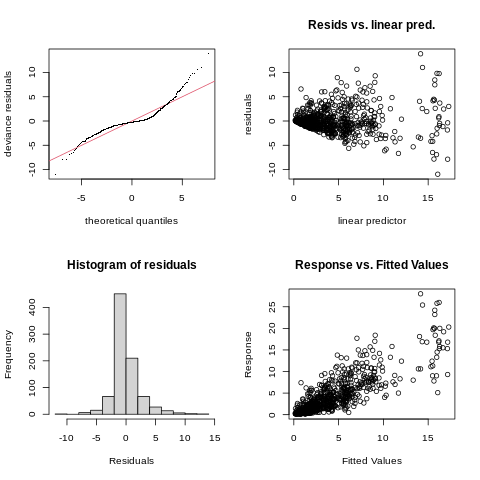

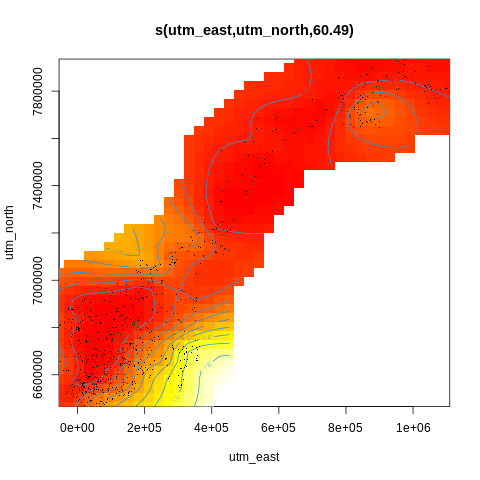

In [9]:
%%R

toc_model1 = gam(
    TOC_mgpl ~ s(utm_east, utm_north, k=100),# + s(runoff_mmpyr) + s(elevation_m),
    data = df,
    select = TRUE,
    method = "REML",
    family = gaussian,
)

print("# Fit summary #################################################")
print(summary(toc_model1))
print('')
print("# Diagnostic checks ###########################################")
gam.check(toc_model1)
concurvity(toc_model1, full=TRUE)

plot(toc_model1, scheme = 2, all.terms = TRUE, shade = TRUE, shift = coef(toc_model1)[1])

### 3.2. Log-normal model

    gam(log(TOC_mgpl) ~ s(utm_east, utm_north), family = gaussian)

[1] "# Fit summary #################################################"

Family: gaussian 
Link function: identity 

Formula:
log(TOC_mgpl) ~ s(utm_east, utm_north, k = 200)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.67255    0.01876   35.86   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                        edf Ref.df     F p-value    
s(utm_east,utm_north) 115.9    199 16.29  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.79   Deviance explained = 81.8%
-REML = 861.42  Scale est. = 0.30359   n = 863
[1] ""
[1] "# Diagnostic checks ###########################################"

Method: REML   Optimizer: outer newton
full convergence after 10 iterations.
Gradient range [-2.602181e-06,1.655573e-06]
(score 861.4211 & scale 0.3035941).
Hessian positive definite, eigenvalue range [0.2156223,439.0525].
Model rank =  2

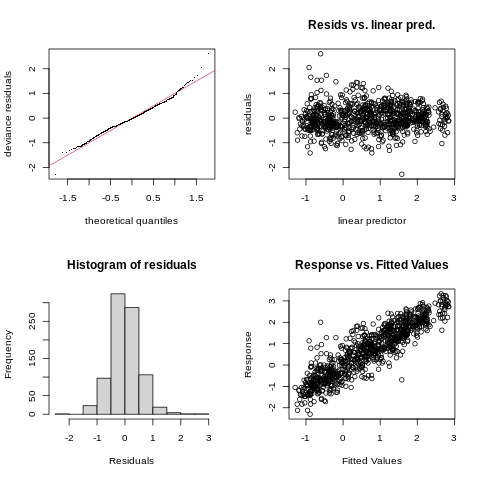

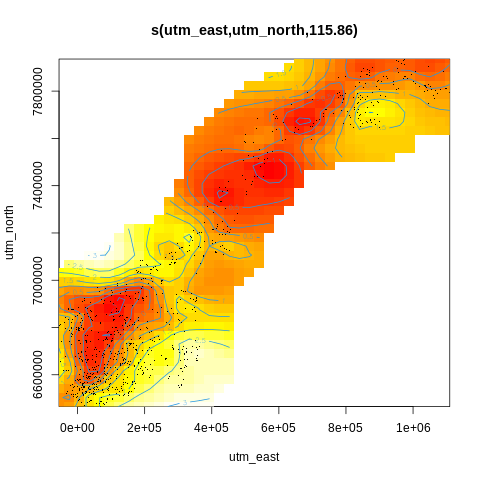

In [11]:
%%R

toc_model2 = gam(
    log(TOC_mgpl) ~ s(utm_east, utm_north, k=200),# + s(runoff_mmpyr) + s(elevation_m),
    data = df,
    select = TRUE,
    method = "REML",
    family = gaussian,
)

print("# Fit summary #################################################")
print(summary(toc_model2))
print('')
print("# Diagnostic checks ###########################################")
gam.check(toc_model2)
concurvity(toc_model2, full=TRUE)

plot(toc_model2, scheme = 2, all.terms = TRUE, shade = TRUE, shift = coef(toc_model2)[1])

### 3.3. Gamma model with log-link

    gam(TOC_mgpl ~ s(utm_east, utm_north), family = Gamma(link = 'log'))

[1] "# Fit summary #################################################"

Family: Gamma 
Link function: log 

Formula:
TOC_mgpl ~ s(utm_east, utm_north, k = 200)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.80105    0.02025   39.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                        edf Ref.df     F p-value    
s(utm_east,utm_north) 125.6    199 13.34  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.736   Deviance explained =   80%
-REML = 1471.9  Scale est. = 0.35395   n = 863
[1] ""
[1] "# Diagnostic checks ###########################################"

Method: REML   Optimizer: outer newton
full convergence after 11 iterations.
Gradient range [-2.883946e-05,1.441067e-05]
(score 1471.911 & scale 0.3539481).
Hessian positive definite, eigenvalue range [0.1512887,479.9532].
Model rank =  200 / 200 

Ba

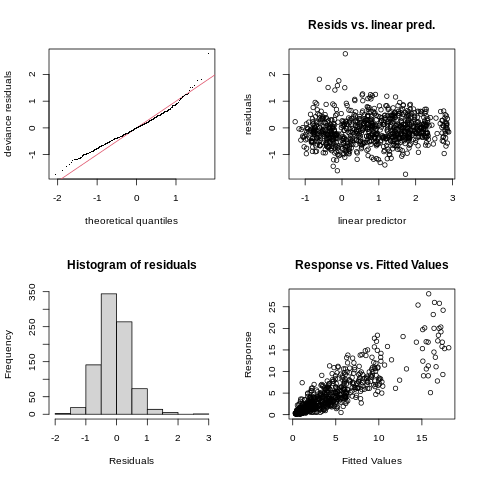

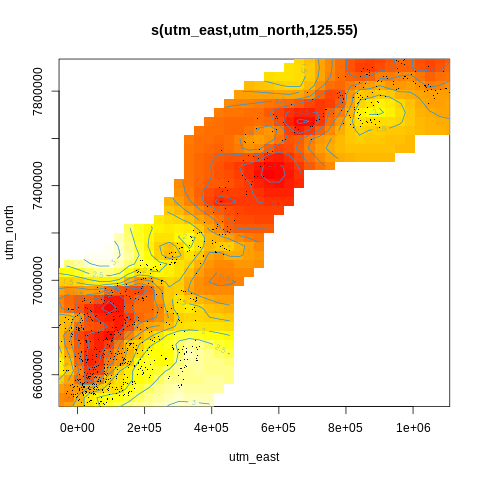

In [13]:
%%R

toc_model3 = gam(
    TOC_mgpl ~ s(utm_east, utm_north, k=200),# + s(runoff_mmpyr) + s(elevation_m),
    data = df,
    select = TRUE,
    method = "REML",
    family = Gamma(link = 'log'),
)

print("# Fit summary #################################################")
print(summary(toc_model3))
print('')
print("# Diagnostic checks ###########################################")
gam.check(toc_model3)
concurvity(toc_model3, full=TRUE)

plot(toc_model3, scheme = 2, all.terms = TRUE, shade = TRUE, shift = coef(toc_model3)[1])

### 3.4. Tensor Gamma model with log-link

    gam(TOC_mgpl ~ te(utm_east, utm_north), family = Gamma(link = 'log'))

[1] "# Fit summary #################################################"

Family: Gamma 
Link function: log 

Formula:
TOC_mgpl ~ te(utm_east, utm_north, k = c(15, 15))

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.85100    0.02353   36.16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                         edf Ref.df     F p-value    
te(utm_east,utm_north) 61.89    174 10.13  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.692   Deviance explained = 72.3%
-REML = 1518.8  Scale est. = 0.47797   n = 863
[1] ""
[1] "# Diagnostic checks ###########################################"

Method: REML   Optimizer: outer newton
full convergence after 4 iterations.
Gradient range [-0.0001019693,8.838341e-06]
(score 1518.833 & scale 0.4779731).
Hessian positive definite, eigenvalue range [5.783089e-05,482.7655].
Model rank =  225

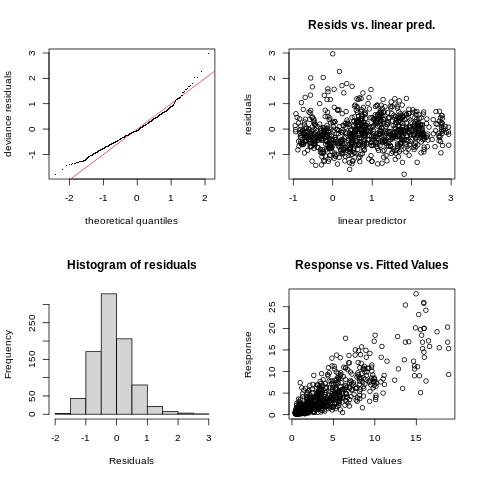

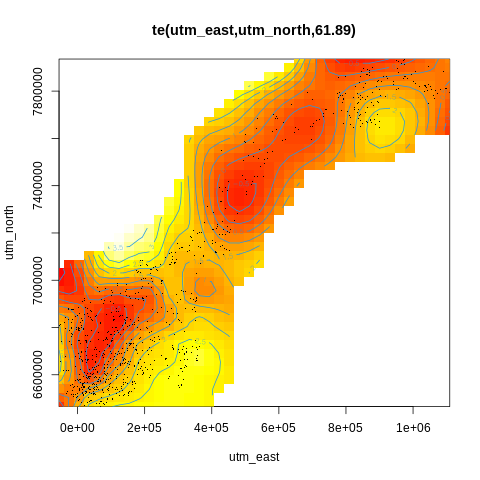

In [20]:
%%R

toc_model4 = gam(
    TOC_mgpl ~ te(utm_east, utm_north, k=c(15, 15)),#, runoff_mmpyr, elevation_m),
    data = df,
    select = TRUE, 
    method = "REML", 
    family = Gamma(link = 'log'),
)

print("# Fit summary #################################################")
print(summary(toc_model4))
print('')
print("# Diagnostic checks ###########################################")
gam.check(toc_model4)
concurvity(toc_model4, full=TRUE)

plot(toc_model4, scheme = 2, all.terms = TRUE, shade = TRUE, shift = coef(toc_model4)[1])

### 3.5. Select model for TOC

The "standard" model is clearly not appropriate due to non-Gaussian and heteroscedastic residuals. The log-normal model looks good, but will require bias correction when used to make predictions, which is fiddly. The fitted splines in the log-normal model are virtually identical to those for the spline-only Gamma model, which is interesting i.e. the "linear predictor" parts are virtually identical, but the way they are used and what the models predict are different. 

The two Gamma models (spline and tensor) are similar: they both look valid and the deviance explained is around 85%. Based on AIC, the tensor model seems best of all, followed by the log-normal and then the Gamma (see below). However, they all seem adequate and I think I prefer the spline model, as it is easier to visualise the effects of elevation and runoff (i.e. TOC concentrations tend to be lower at higher elevations and in places with higher runoff) and it will be easier to use for prediction. Furthermore, looking at the diagnostic plots, the tensor model seems to slightly underpredict `y`

Overall, I think **the spline-only Gamma model with a log-link is probably the one to use**.

In [21]:
%%R

# Apply correction factor to AIC for logged model. See
# https://stats.stackexchange.com/a/550579/5467
aic_adjust = 2*sum(log(df$TOC_mgpl))
AIC(toc_model2, toc_model3, toc_model4) + matrix(ncol=2, c(0, 0, 0, aic_adjust, 0, 0))

                  df      AIC
toc_model2 119.80031 2695.198
toc_model3 129.42859 2741.632
toc_model4  66.89727 2906.408


In [22]:
%%R

# Save 'best' model for use later
best_model = toc_model3
saveRDS(best_model, "best_toc_model.rds")

## 4. Models for NO3 (full time period)

**Important!**

Including runoff and elevation in the models for nitrate makes fitting extremely slow, so it is difficult to explore options effectively. It also produces some dubious relationships, in the sense that `gam.check` implies the number of knots for these variables should be high, but the their effect then becomes unrealistically wiggly (e.g. small changes in runoff completely change the direction of the effect on NO3). 

We can perhaps revisit this, but **for now I am just using space and time as predictor variables for NO3**.

In [12]:
no3_df = df.dropna(subset=["NO3_NO2_ugpl"]).copy()
del no3_df["TOC_mgpl"]
no3_csv_path = (
    r"/home/jovyan/shared/critical_loads/spatial_interpolation/norway_annual_no3.csv"
)
no3_df.to_csv(no3_csv_path)
no3_df.describe()

,station_id,utm_north,utm_east,year,NO3_NO2_ugpl,runoff_mmpyr,elevation_m
count,5032.000000,5.032000e+03,5.032000e+03,5032.000000,5032.000000,5032.000000,5032.000000
mean,14091.059221,6.919763e+06,2.833864e+05,2005.369237,53.014126,1501.690580,539.658983
std,13978.823921,4.421712e+05,3.210376e+05,9.936850,70.961206,942.377942,366.881809
min,100.000000,6.465531e+06,-5.524240e+04,1990.000000,1.000000,283.000000,2.000000
25%,149.000000,6.587288e+06,5.379293e+04,1995.000000,7.000000,667.000000,247.000000
50%,26074.000000,6.742695e+06,1.674203e+05,2003.000000,28.000000,1282.000000,449.000000
75%,26395.000000,7.117452e+06,3.406150e+05,2016.000000,72.000000,2053.000000,781.000000
max,71725.000000,7.935722e+06,1.109404e+06,2021.000000,550.000000,4760.000000,1758.000000


In [13]:
%%R

# Read dataset
df = read.csv(
    "/home/jovyan/shared/critical_loads/spatial_interpolation/norway_annual_no3.csv"
)

### 4.1. "Standard" model

    gam(NO3_NO2_ugpl ~ s(utm_east, utm_north) + s(year), family = gaussian)

[1] "# Fit summary #################################################"

Family: gaussian 
Link function: identity 

Formula:
NO3_NO2_ugpl ~ s(utm_east, utm_north, k = 700) + s(year, k = 30)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  53.0141     0.3908   135.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                         edf Ref.df     F p-value    
s(utm_east,utm_north) 521.46    699 37.59  <2e-16 ***
s(year)                10.53     29 37.80  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.847   Deviance explained = 86.4%
-REML =  24739  Scale est. = 768.37    n = 5032
[1] ""
[1] "# Diagnostic checks ###########################################"

Method: REML   Optimizer: outer newton
full convergence after 4 iterations.
Gradient range [-0.0003054617,9.85769e-06]
(score 24738.68 & scale 768.3695).
eigenvalue

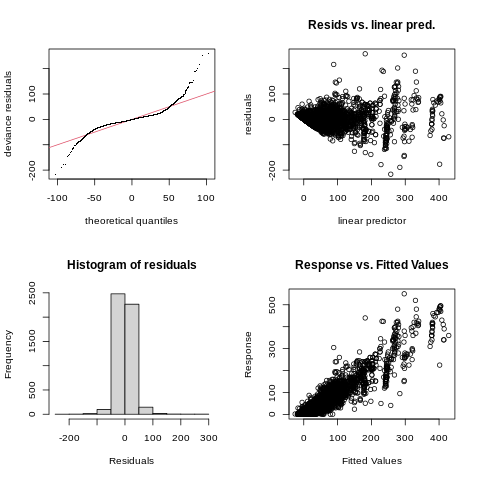

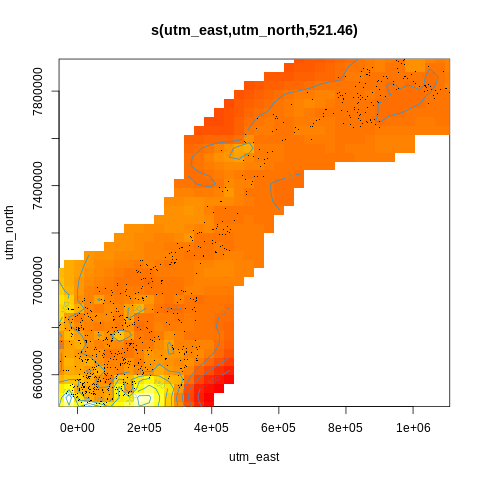

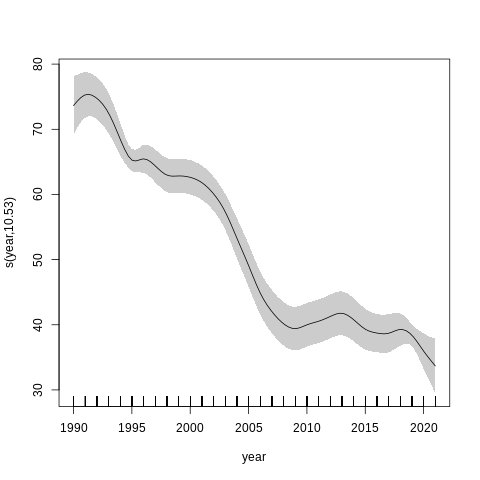

In [14]:
%%R

no3_model1 = gam(
    NO3_NO2_ugpl ~ s(utm_east, utm_north, k=700) + s(year, k=30), # + s(runoff_mmpyr, k=100) + s(elevation_m, k=100),
    # NO3_NO2_ugpl ~ s(utm_east, utm_north) + s(runoff_mmpyr) + s(elevation_m),
    data = df,
    select = TRUE,
    method = "REML",
    family = gaussian,
)

print("# Fit summary #################################################")
print(summary(no3_model1))
print('')
print("# Diagnostic checks ###########################################")
gam.check(no3_model1)
concurvity(no3_model1, full=TRUE)

plot(no3_model1, scheme = 2, all.terms = TRUE, shade = TRUE, shift = coef(no3_model1)[1])

### 4.2. Log-normal model

    gam(log(NO3_NO2_ugpl) ~ s(utm_east, utm_north) + s(year), family = gaussian)

[1] "# Fit summary #################################################"

Family: gaussian 
Link function: identity 

Formula:
log(NO3_NO2_ugpl) ~ s(utm_east, utm_north, k = 700) + s(year, 
    k = 30)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.037789   0.009283   327.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                          edf Ref.df     F p-value    
s(utm_east,utm_north) 485.500    699 32.19  <2e-16 ***
s(year)                 7.855     29 34.60  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.828   Deviance explained = 84.5%
-REML =   5824  Scale est. = 0.43361   n = 5032
[1] ""
[1] "# Diagnostic checks ###########################################"

Method: REML   Optimizer: outer newton
full convergence after 4 iterations.
Gradient range [-0.0004820873,3.161315e-05]
(score 5824.028 & scale 0.43361

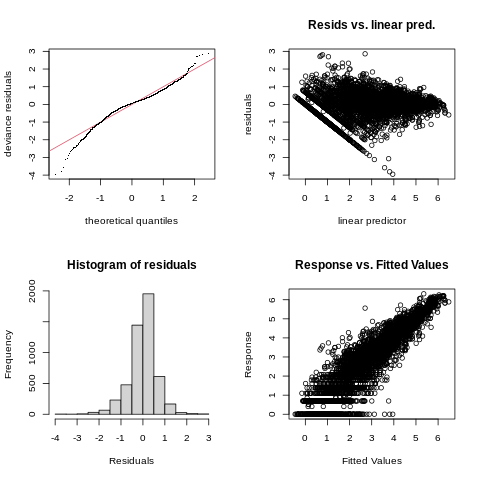

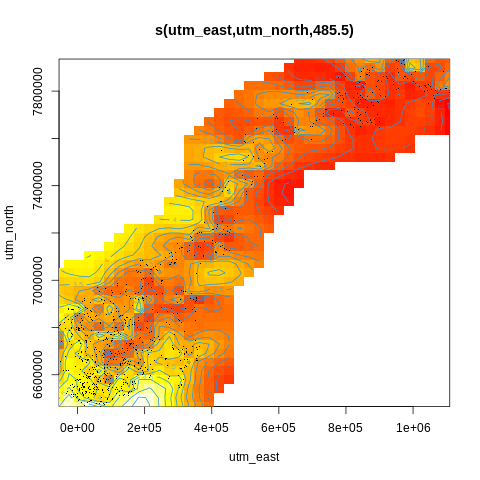

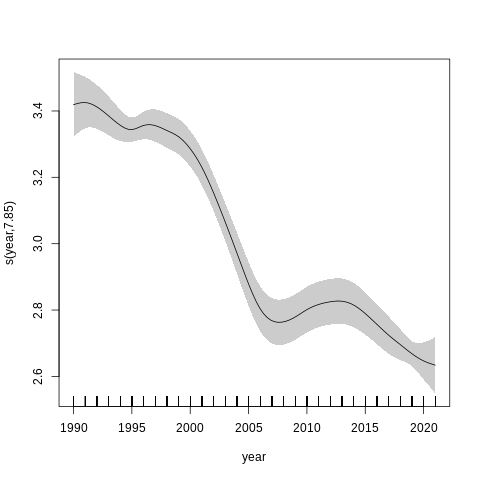

In [15]:
%%R

no3_model2 = gam(
    log(NO3_NO2_ugpl) ~ s(utm_east, utm_north, k=700) + s(year, k=30), # + s(runoff_mmpyr, k=20) + s(elevation_m, k=20),
    # log(NO3_NO2_ugpl) ~ s(utm_east, utm_north) + s(runoff_mmpyr) + s(elevation_m),
    data = df,
    select = TRUE,
    method = "REML",
    family = gaussian,
)

print("# Fit summary #################################################")
print(summary(no3_model2))
print('')
print("# Diagnostic checks ###########################################")
gam.check(no3_model2)
concurvity(no3_model2, full=TRUE)

plot(no3_model2, scheme = 2, all.terms = TRUE, shade = TRUE, shift = coef(no3_model2)[1])

### 4.3. Gamma model with log-link

    gam(NO3_NO2_ugpl ~ s(utm_east, utm_north) + s(year), family = Gamma(link = 'log'))

[1] "# Fit summary #################################################"

Family: Gamma 
Link function: log 

Formula:
NO3_NO2_ugpl ~ s(utm_east, utm_north, k = 700) + s(year, k = 30)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.206345   0.008072   397.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                          edf Ref.df     F p-value    
s(utm_east,utm_north) 494.796    699 38.28  <2e-16 ***
s(year)                 6.205     29 39.84  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.855   Deviance explained = 81.9%
-REML =  20891  Scale est. = 0.32784   n = 5032
[1] ""
[1] "# Diagnostic checks ###########################################"

Method: REML   Optimizer: outer newton
full convergence after 4 iterations.
Gradient range [-3.646296e-05,9.087854e-05]
(score 20890.58 & scale 0.3278383).
eigenvalue ra

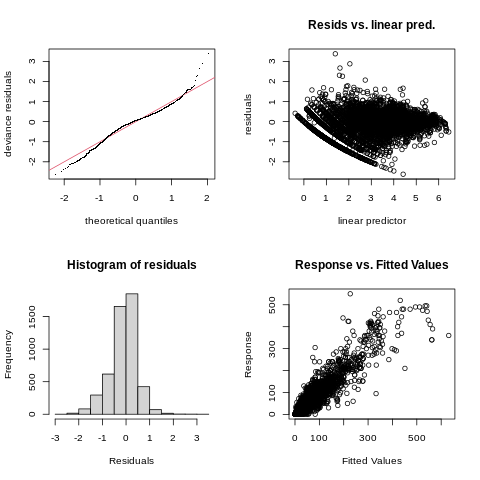

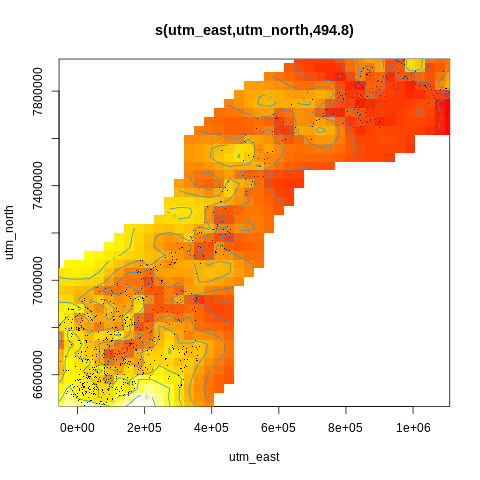

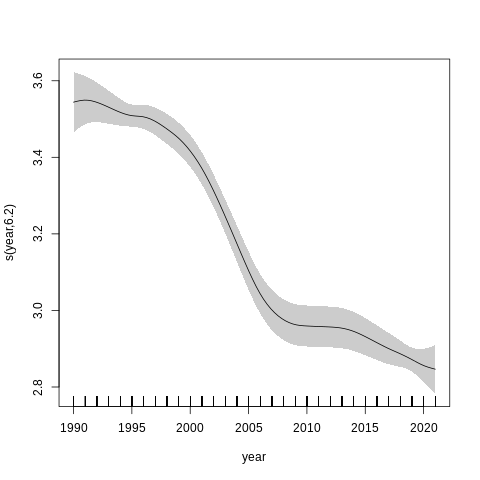

In [16]:
%%R

no3_model3 = gam(
    NO3_NO2_ugpl ~ s(utm_east, utm_north, k=700) + s(year, k=30),# + s(runoff_mmpyr) + s(elevation_m),
    # NO3_NO2_ugpl ~ s(utm_east, utm_north) + s(runoff_mmpyr) + s(elevation_m),
    data = df,
    select = TRUE,
    method = "REML",
    family = Gamma(link = 'log'),
)

print("# Fit summary #################################################")
print(summary(no3_model3))
print('')
print("# Diagnostic checks ###########################################")
gam.check(no3_model3)
concurvity(no3_model3, full=TRUE)

plot(no3_model3, scheme = 2, all.terms = TRUE, shade = TRUE, shift = coef(no3_model3)[1])

### 4.4. Tensor Gamma model with log-link

    gam(NO3_NO2_ugpl ~ te(utm_east, utm_north, year), family = Gamma(link = 'log')

[1] "# Fit summary #################################################"

Family: Gamma 
Link function: log 

Formula:
NO3_NO2_ugpl ~ te(utm_east, utm_north, year, k = c(15, 15, 4))

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.30865    0.01081   306.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                              edf Ref.df  F p-value    
te(utm_east,utm_north,year) 268.6    654 20  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.759   Deviance explained =   71%
-REML =  21675  Scale est. = 0.58794   n = 5032
[1] ""
[1] "# Diagnostic checks ###########################################"

Method: REML   Optimizer: outer newton
full convergence after 9 iterations.
Gradient range [-0.01384588,0.005589266]
(score 21674.64 & scale 0.5879373).
Hessian positive definite, eigenvalue range [0.262945,2937.077].
Model 

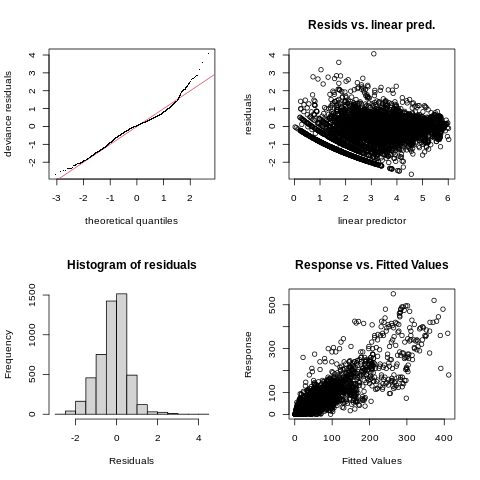

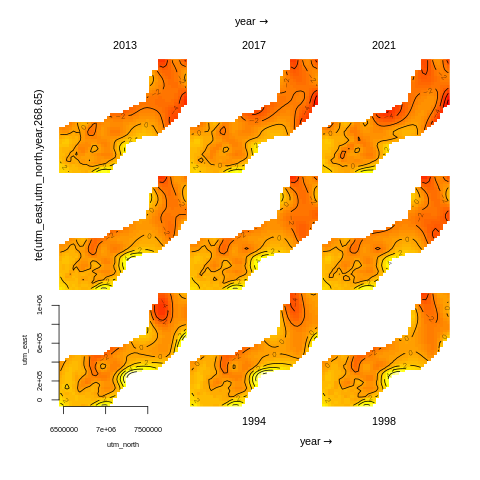

In [17]:
%%R

no3_model4 = gam(
    NO3_NO2_ugpl ~ te(utm_east, utm_north, year, k=c(15, 15, 4)), #runoff_mmpyr, elevation_m),
    # NO3_NO2_ugpl ~ te(utm_east, utm_north, runoff_mmpyr, elevation_m),
    data = df,
    select = TRUE,
    method = "REML",
    family = Gamma(link = 'log'),
)

print("# Fit summary #################################################")
print(summary(no3_model4))
print('')
print("# Diagnostic checks ###########################################")
gam.check(no3_model4)
concurvity(no3_model4, full=TRUE)

plot(no3_model4, scheme = 2, all.terms = TRUE, shade = TRUE, shift = coef(no3_model4)[1])

### 4.5. Select model for NO3

Results are similar to those for TOC: the "standard" model for NO3 is not appropriate due to non-Gaussian and strongly heteroscedastic residuals; the distribution for the log-normal model is also not great - it seems to reduce the variance at high values of `y` too much; the spline-only Gamma model with a log-link is similar, but looks slightly better (confirmed by the AIC - see below); and the tensor-based Gamma model is also OK, but seems to under-predict values for `y`.

All the models have a weird pattern in the residuals due to the high proportion of censored/LOD values in the NO3 dataset, which is not a problem for TOC.

Following similar reasoning for TOC, I think **the spline-only Gamma model is the best**, and it also has the lowest AIC (see below). However, all these models have some issues: there is still obvious structure in the residuals, and `gam.check` suggests the number of knots for `s(year)` is too low, even though it can't be any higher due to limitations in the data (and 30 knots should be more than enough anyway!). All this implies we're missing some additional covariates to explain patterns in the data - especially the pattern through time. Perhaps if we had estimates of changing runoff over time, instead of the long-term mean grid, that would be better?

Nevertheless, the "deviance explained" of 80% is pretty good and the model may still be OK for prediction, even if the p-values etc. are a little unreliable.

In [18]:
%%R

# Apply correction factor to AIC for logged model. See
# https://stats.stackexchange.com/a/550579/5467
aic_adjust = 2*sum(log(df$NO3_NO2_ugpl))
AIC(no3_model2, no3_model3, no3_model4) + matrix(ncol=2, c(0, 0, 0, aic_adjust, 0, 0))

                 df      AIC
no3_model2 497.8757 41123.11
no3_model3 506.1445 40691.83
no3_model4 274.5121 42755.74


In [19]:
%%R

# Save 'best' model for use later
best_model = no3_model3
saveRDS(best_model, "best_no3_model.rds")